<a href="https://colab.research.google.com/github/cyloic/Time-Series-Forecasting/blob/main/air_quality_forecasting_starter_code_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beijing Air Quality Forecasting Starter Notebook

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30676 entries, 2010-01-01 00:00:00 to 2013-07-02 03:00:00
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   No       30676 non-null  int64  
 1   DEWP     30676 non-null  float64
 2   TEMP     30676 non-null  float64
 3   PRES     30676 non-null  float64
 4   Iws      30676 non-null  float64
 5   Is       30676 non-null  float64
 6   Ir       30676 non-null  float64
 7   cbwd_NW  30676 non-null  float64
 8   cbwd_SE  30676 non-null  float64
 9   cbwd_cv  30676 non-null  float64
 10  pm2.5    30676 non-null  float64
dtypes: float64(10), int64(1)
memory usage: 2.8 MB
None
                 No          DEWP          TEMP          PRES           Iws  \
count  30676.000000  30676.000000  30676.000000  30676.000000  30676.000000   
mean   15338.500000     -0.029431     -0.062712      0.013612      0.030542   
std     8855.542765      0.994087      1.015193      1.008991      1.

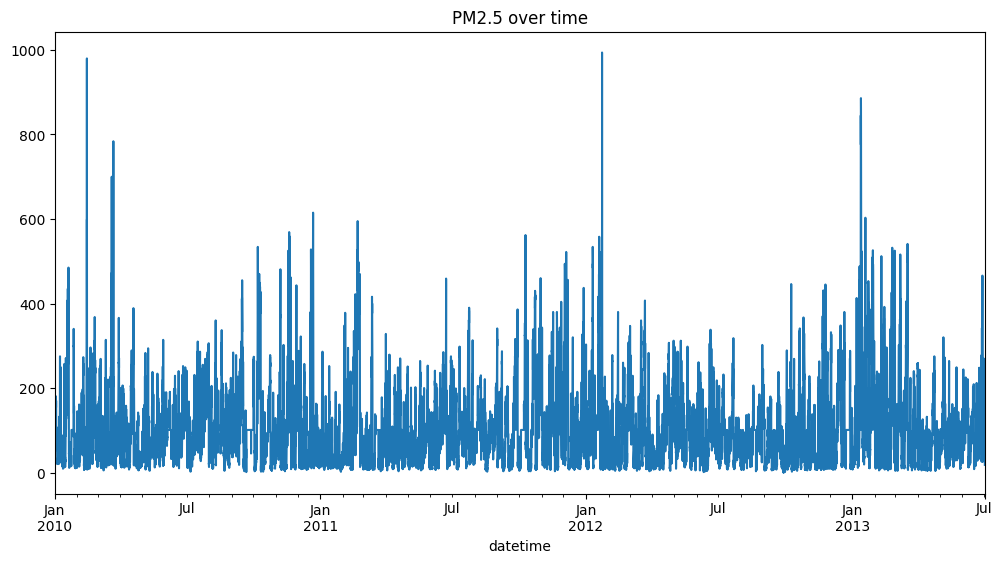

In [ ]:
print(train.info())
print(train.describe())
print(train.isnull().sum())

plt.figure(figsize=(12,6))
train['pm2.5'].plot(title='PM2.5 over time')
plt.show()

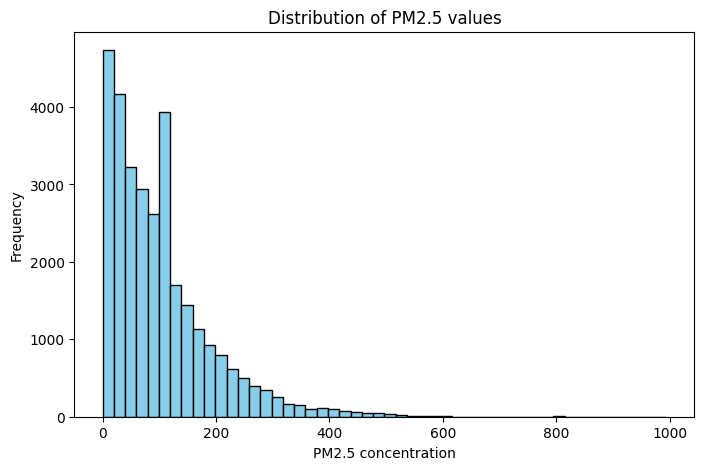

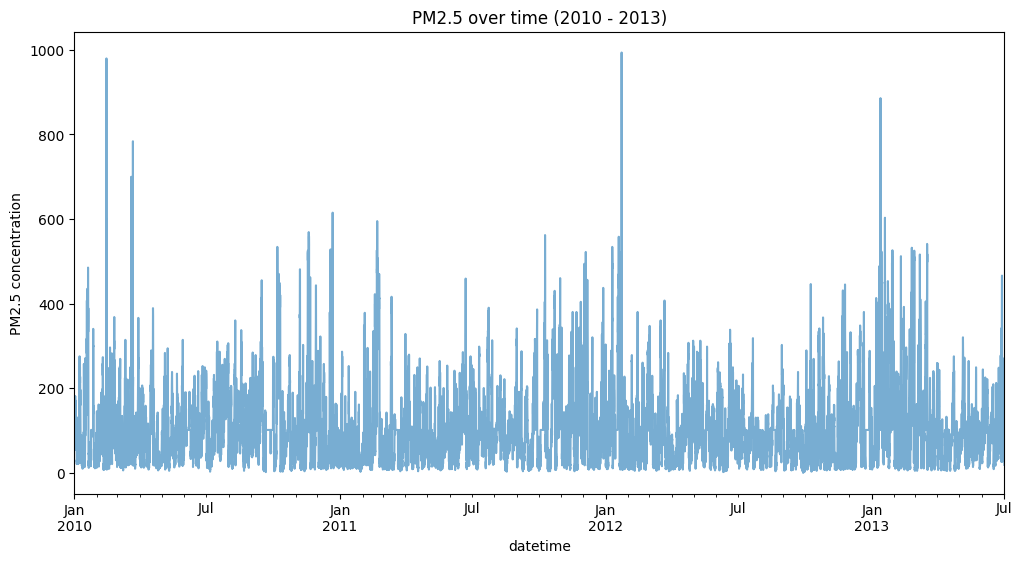

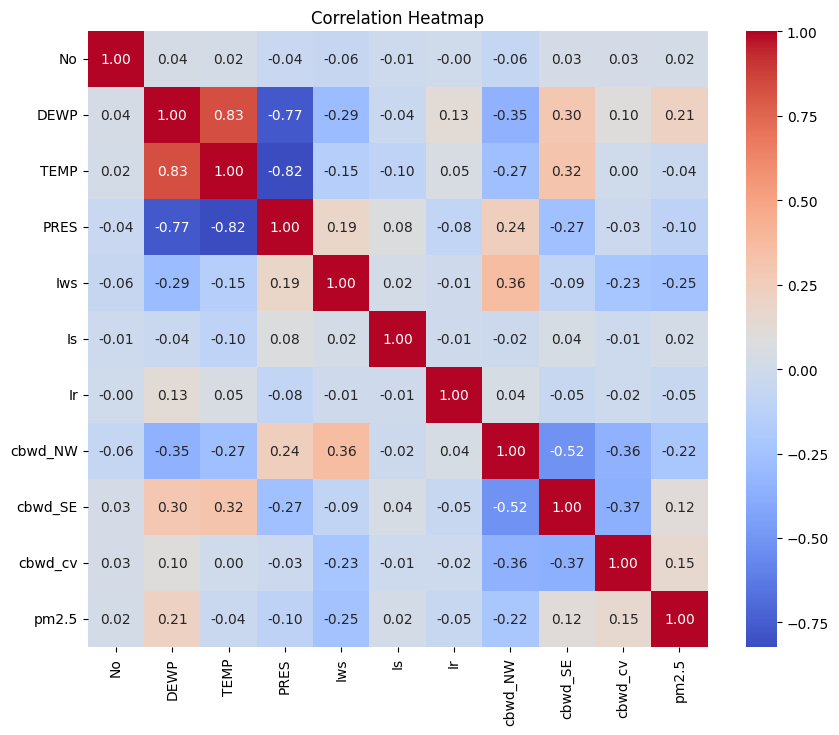

In [ ]:
# Distribution of target variable (pm2.5)
plt.figure(figsize=(8,5))
plt.hist(train['pm2.5'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of PM2.5 values")
plt.xlabel("PM2.5 concentration")
plt.ylabel("Frequency")
plt.show()

# Time series plot of PM2.5
plt.figure(figsize=(12,6))
train['pm2.5'].plot(alpha=0.6)
plt.title("PM2.5 over time (2010 - 2013)")
plt.ylabel("PM2.5 concentration")
plt.show()

# Correlation heatmap
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(train.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# Feature Engineering: Extract time-based features
for df in [train, test]:
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['weekday'] = df.index.weekday

# Quick check of new features
print(train[['hour', 'day', 'month', 'weekday']].head())

                     hour  day  month  weekday
datetime                                      
2010-01-01 00:00:00     0    1      1        4
2010-01-01 01:00:00     1    1      1        4
2010-01-01 02:00:00     2    1      1        4
2010-01-01 03:00:00     3    1      1        4
2010-01-01 04:00:00     4    1      1        4


In [ ]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [ ]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [ ]:
# Handle missing values (safety check)
for df in [train, test]:
    df.interpolate(method='time', inplace=True)   # fill using time interpolation
    df.fillna(method='bfill', inplace=True)      # backfill as fallback
    df.fillna(method='ffill', inplace=True)      # forward fill as last resort

# Verify again
print("Missing values after handling:")
print(train.isnull().sum())
print(test.isnull().sum())

Missing values after handling:
No         0
DEWP       0
TEMP       0
PRES       0
Iws        0
Is         0
Ir         0
cbwd_NW    0
cbwd_SE    0
cbwd_cv    0
pm2.5      0
hour       0
day        0
month      0
weekday    0
dtype: int64
No         0
DEWP       0
TEMP       0
PRES       0
Iws        0
Is         0
Ir         0
cbwd_NW    0
cbwd_SE    0
cbwd_cv    0
hour       0
day        0
month      0
weekday    0
dtype: int64


/tmp/ipython-input-2672203032.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)      # backfill as fallback
/tmp/ipython-input-2672203032.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)      # forward fill as last resort
/tmp/ipython-input-2672203032.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)      # backfill as fallback
/tmp/ipython-input-2672203032.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)      # forward fill as last resort


# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [ ]:
# Separate features (X) and target (y)
X_train = train.drop(['pm2.5', 'No'], axis=1)
y_train = train['pm2.5']

# Check shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (30676, 13)
y_train shape: (30676,)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Scale features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Reshape for LSTM (samples, timesteps, features)
X_train_scaled = np.expand_dims(X_train_scaled, axis=1)

print("X_train_scaled shape:", X_train_scaled.shape)

X_train_scaled shape: (30676, 1, 13)


# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

# --- Experiment Parameters ---
units_1 = 64            # First LSTM layer units
units_2 = 32            # Second LSTM layer units
dropout_rate = 0.3      # Dropout to prevent overfitting
learning_rate = 0.001   # Adam learning rate

optimizer_choice = Adam(learning_rate=learning_rate)

# --- Build Model ---
model = Sequential([
    Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),
    LSTM(units_1, activation='tanh', return_sequences=True),
    Dropout(dropout_rate),
    LSTM(units_2, activation='tanh'),
    Dropout(dropout_rate),
    Dense(1, activation='linear')
])

# Compile Model
model.compile(
    optimizer=optimizer_choice,
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

model.summary()

# --- Callbacks ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,417 (126.63 KB)

 Trainable params: 32,417 (126.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# --- Callbacks ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# --- Train Model ---
history = model.fit(
    X_train_scaled, y_train,
    epochs=80,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/80
374/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16097.8438 - rmse: 126.8008
Epoch 1: val_loss improved from inf to 20021.20703, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 16067.5254 - rmse: 126.6815 - val_loss: 20021.2070 - val_rmse: 141.4963 - learning_rate: 0.0010
Epoch 2/80
372/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13570.8535 - rmse: 116.4772
Epoch 2: val_loss improved from 20021.20703 to 18304.76953, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 13553.7715 - rmse: 116.4037 - val_loss: 18304.7695 - val_rmse: 135.2951 - learning_rate: 0.0010
Epoch 3/80
376/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11896.5840 - rmse: 109.0674
Epoch 3: val_loss improved from 18304.76953 to 16903.74609, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 11893.2002 - rmse: 109.0519 - val_loss: 16903.7461 - val_rmse: 130.0144 - learning_rate: 0.0010
Epoch 4/80
366/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10989.0664 - rmse: 104.8187
Epoch 4: val_loss improved from 16903.74609 to 15739.58496, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10975.7490 - rmse: 104.7553 - val_loss: 15739.5850 - val_rmse: 125.4575 - learning_rate: 0.0010
Epoch 5/80
371/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10057.4072 - rmse: 100.2793
Epoch 5: val_loss improved from 15739.58496 to 14771.69922, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 10051.2461 - rmse: 100.2487 - val_loss: 14771.6992 - val_rmse: 121.5389 - learning_rate: 0.0010
Epoch 6/80
381/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9389.7451 - rmse: 96.8892
Epoch 6: val_loss improved from 14771.69922 to 13971.76270, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 9387.9268 - rmse: 96.8799 - val_loss: 13971.7627 - val_rmse: 118.2022 - learning_rate: 0.0010
Epoch 7/80
379/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8925.0117 - rmse: 94.4579
Epoch 7: val_loss improved from 13971.76270 to 13318.73926, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8921.5420 - rmse: 94.4396 - val_loss: 13318.7393 - val_rmse: 115.4068 - learning_rate: 0.0010
Epoch 8/80
383/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8494.9980 - rmse: 92.1590
Epoch 8: val_loss improved from 13318.73926 to 12797.15820, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 8493.9971 - rmse: 92.1536 - val_loss: 12797.1582 - val_rmse: 113.1245 - learning_rate: 0.0010
Epoch 9/80
383/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7986.2866 - rmse: 89.3600
Epoch 9: val_loss improved from 12797.15820 to 12384.75391, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7986.3545 - rmse: 89.3605 - val_loss: 12384.7539 - val_rmse: 111.2868 - learning_rate: 0.0010
Epoch 10/80
379/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7798.4497 - rmse: 88.3015
Epoch 10: val_loss improved from 12384.75391 to 12065.08594, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7798.5288 - rmse: 88.3020 - val_loss: 12065.0859 - val_rmse: 109.8412 - learning_rate: 0.0010
Epoch 11/80
383/384 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7666.8945 - rmse: 87.5505
Epoch 11: val_loss improved from 12065.08594 to 11831.28906, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7666.8027 - rmse: 87.5500 - val_loss: 11831.2891 - val_rmse: 108.7717 - learning_rate: 0.0010
Epoch 12/80
382/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7458.9512 - rmse: 86.3578
Epoch 12: val_loss improved from 11831.28906 to 11659.56348, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7459.8354 - rmse: 86.3630 - val_loss: 11659.5635 - val_rmse: 107.9795 - learning_rate: 0.0010
Epoch 13/80
378/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7622.3193 - rmse: 87.2998
Epoch 13: val_loss improved from 11659.56348 to 11542.86035, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7620.5337 - rmse: 87.2897 - val_loss: 11542.8604 - val_rmse: 107.4377 - learning_rate: 0.0010
Epoch 14/80
377/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7327.4585 - rmse: 85.5758
Epoch 14: val_loss improved from 11542.86035 to 11465.76270, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7330.7974 - rmse: 85.5957 - val_loss: 11465.7627 - val_rmse: 107.0783 - learning_rate: 0.0010
Epoch 15/80
382/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7238.2764 - rmse: 85.0689
Epoch 15: val_loss improved from 11465.76270 to 10650.45898, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7238.2319 - rmse: 85.0687 - val_loss: 10650.4590 - val_rmse: 103.2011 - learning_rate: 0.0010
Epoch 16/80
380/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6503.2378 - rmse: 80.6299
Epoch 16: val_loss improved from 10650.45898 to 9998.25000, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6504.7832 - rmse: 80.6396 - val_loss: 9998.2500 - val_rmse: 99.9912 - learning_rate: 0.0010
Epoch 17/80
370/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6309.2905 - rmse: 79.3960
Epoch 17: val_loss improved from 9998.25000 to 9515.21973, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6309.6680 - rmse: 79.3997 - val_loss: 9515.2197 - val_rmse: 97.5460 - learning_rate: 0.0010
Epoch 18/80
360/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6127.5972 - rmse: 78.2696
Epoch 18: val_loss improved from 9515.21973 to 9120.46289, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6120.1895 - rmse: 78.2226 - val_loss: 9120.4629 - val_rmse: 95.5011 - learning_rate: 0.0010
Epoch 19/80
375/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5735.1104 - rmse: 75.7226
Epoch 19: val_loss improved from 9120.46289 to 8867.73535, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5738.3105 - rmse: 75.7438 - val_loss: 8867.7354 - val_rmse: 94.1687 - learning_rate: 0.0010
Epoch 20/80
383/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5926.3223 - rmse: 76.9525
Epoch 20: val_loss improved from 8867.73535 to 8655.40723, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5925.4502 - rmse: 76.9469 - val_loss: 8655.4072 - val_rmse: 93.0344 - learning_rate: 0.0010
Epoch 21/80
377/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5753.0815 - rmse: 75.8363
Epoch 21: val_loss improved from 8655.40723 to 8503.60254, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5751.1860 - rmse: 75.8240 - val_loss: 8503.6025 - val_rmse: 92.2150 - learning_rate: 0.0010
Epoch 22/80
367/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5710.1221 - rmse: 75.5415
Epoch 22: val_loss improved from 8503.60254 to 8378.68359, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5704.1724 - rmse: 75.5030 - val_loss: 8378.6836 - val_rmse: 91.5351 - learning_rate: 0.0010
Epoch 23/80
376/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5325.6353 - rmse: 72.9498
Epoch 23: val_loss improved from 8378.68359 to 8288.94922, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5330.7266 - rmse: 72.9850 - val_loss: 8288.9492 - val_rmse: 91.0437 - learning_rate: 0.0010
Epoch 24/80
381/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5686.8965 - rmse: 75.4064
Epoch 24: val_loss improved from 8288.94922 to 8092.63574, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5685.2573 - rmse: 75.3955 - val_loss: 8092.6357 - val_rmse: 89.9591 - learning_rate: 0.0010
Epoch 25/80
373/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5567.1743 - rmse: 74.5973
Epoch 25: val_loss improved from 8092.63574 to 8013.28271, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5564.3467 - rmse: 74.5788 - val_loss: 8013.2827 - val_rmse: 89.5169 - learning_rate: 0.0010
Epoch 26/80
364/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5336.6704 - rmse: 73.0257
Epoch 26: val_loss improved from 8013.28271 to 7946.00635, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5343.1201 - rmse: 73.0711 - val_loss: 7946.0063 - val_rmse: 89.1404 - learning_rate: 0.0010
Epoch 27/80
364/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5226.0176 - rmse: 72.2749
Epoch 27: val_loss improved from 7946.00635 to 7811.27051, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5234.8960 - rmse: 72.3368 - val_loss: 7811.2705 - val_rmse: 88.3814 - learning_rate: 0.0010
Epoch 28/80
379/384 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5330.4961 - rmse: 72.9932
Epoch 28: val_loss improved from 7811.27051 to 7797.59766, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5331.1147 - rmse: 72.9977 - val_loss: 7797.5977 - val_rmse: 88.3040 - learning_rate: 0.0010
Epoch 29/80
366/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5304.6602 - rmse: 72.8231
Epoch 29: val_loss improved from 7797.59766 to 7645.87500, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5306.3584 - rmse: 72.8352 - val_loss: 7645.8750 - val_rmse: 87.4407 - learning_rate: 0.0010
Epoch 30/80
371/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5292.4771 - rmse: 72.7359
Epoch 30: val_loss improved from 7645.87500 to 7594.43750, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5292.8047 - rmse: 72.7386 - val_loss: 7594.4375 - val_rmse: 87.1461 - learning_rate: 0.0010
Epoch 31/80
383/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5174.7363 - rmse: 71.9250
Epoch 31: val_loss improved from 7594.43750 to 7584.48682, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5175.2129 - rmse: 71.9284 - val_loss: 7584.4868 - val_rmse: 87.0890 - learning_rate: 0.0010
Epoch 32/80
379/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5171.3794 - rmse: 71.9045
Epoch 32: val_loss improved from 7584.48682 to 7466.89697, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 5172.6670 - rmse: 71.9136 - val_loss: 7466.8970 - val_rmse: 86.4112 - learning_rate: 0.0010
Epoch 33/80
377/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5311.1890 - rmse: 72.8685
Epoch 33: val_loss improved from 7466.89697 to 7422.26318, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5309.5781 - rmse: 72.8576 - val_loss: 7422.2632 - val_rmse: 86.1526 - learning_rate: 0.0010
Epoch 34/80
379/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5383.4683 - rmse: 73.3646
Epoch 34: val_loss improved from 7422.26318 to 7366.33594, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5380.6836 - rmse: 73.3456 - val_loss: 7366.3359 - val_rmse: 85.8274 - learning_rate: 0.0010
Epoch 35/80
372/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4987.0396 - rmse: 70.6049
Epoch 35: val_loss improved from 7366.33594 to 7300.83398, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4993.6543 - rmse: 70.6517 - val_loss: 7300.8340 - val_rmse: 85.4449 - learning_rate: 0.0010
Epoch 36/80
383/384 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4959.0708 - rmse: 70.4111
Epoch 36: val_loss improved from 7300.83398 to 7218.70215, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4960.3916 - rmse: 70.4204 - val_loss: 7218.7021 - val_rmse: 84.9629 - learning_rate: 0.0010
Epoch 37/80
374/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5146.5181 - rmse: 71.7241
Epoch 37: val_loss improved from 7218.70215 to 7200.61670, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5146.3198 - rmse: 71.7231 - val_loss: 7200.6167 - val_rmse: 84.8564 - learning_rate: 0.0010
Epoch 38/80
372/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4940.3101 - rmse: 70.2717
Epoch 38: val_loss did not improve from 7200.61670
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4948.2183 - rmse: 70.3279 - val_loss: 7257.5005 - val_rmse: 85.1910 - learning_rate: 0.0010
Epoch 39/80
363/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5150.7651 - rmse: 71.7492
Epoch 39: val_loss improved from 7200.61670 to 7116.18164, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5149.4043 - rmse: 71.7408 - val_loss: 7116.1816 - val_rmse: 84.3575 - learning_rate: 0.0010
Epoch 40/80
375/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5057.8833 - rmse: 71.1125
Epoch 40: val_loss improved from 7116.18164 to 7072.08105, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5059.2651 - rmse: 71.1223 - val_loss: 7072.0811 - val_rmse: 84.0957 - learning_rate: 0.0010
Epoch 41/80
382/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5098.8223 - rmse: 71.4004
Epoch 41: val_loss did not improve from 7072.08105
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5098.8257 - rmse: 71.4005 - val_loss: 7191.3501 - val_rmse: 84.8018 - learning_rate: 0.0010
Epoch 42/80
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5187.7617 - rmse: 72.0116
Epoch 42: val_loss improved from 7072.08105 to 7023.87988, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5187.5659 - rmse: 72.0102 - val_loss: 7023.8799 - val_rmse: 83.8086 - learning_rate: 0.0010
Epoch 43/80
362/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5272.7354 - rmse: 72.6057
Epoch 43: val_loss improved from 7023.87988 to 7017.44336, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5261.7593 - rmse: 72.5300 - val_loss: 7017.4434 - val_rmse: 83.7702 - learning_rate: 0.0010
Epoch 44/80
372/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5095.3950 - rmse: 71.3761
Epoch 44: val_loss did not improve from 7017.44336
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5094.2275 - rmse: 71.3681 - val_loss: 7059.4365 - val_rmse: 84.0205 - learning_rate: 0.0010
Epoch 45/80
380/384 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5169.4927 - rmse: 71.8878
Epoch 45: val_loss did not improve from 7017.44336
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5167.9644 - rmse: 71.8773 - val_loss: 7025.0210 - val_rmse: 83.8154 - learning_rate: 0.0010
Epoch 46/80
371/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4959.7529 - rmse: 70.4054
Epoch 46: val_loss improved from 7017.44336 to 7008.83838, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4963.5859 - rmse: 70.4332 - val_loss: 7008.8384 - val_rmse: 83.7188 - learning_rate: 0.0010
Epoch 47/80
366/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4934.4312 - rmse: 70.2369
Epoch 47: val_loss did not improve from 7008.83838
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4938.9033 - rmse: 70.2690 - val_loss: 7018.6694 - val_rmse: 83.7775 - learning_rate: 0.0010
Epoch 48/80
375/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5026.5083 - rmse: 70.8803
Epoch 48: val_loss improved from 7008.83838 to 6964.75732, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5025.9653 - rmse: 70.8770 - val_loss: 6964.7573 - val_rmse: 83.4551 - learning_rate: 0.0010
Epoch 49/80
374/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5157.5068 - rmse: 71.8033
Epoch 49: val_loss did not improve from 6964.75732
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5154.0835 - rmse: 71.7797 - val_loss: 7024.0269 - val_rmse: 83.8095 - learning_rate: 0.0010
Epoch 50/80
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4957.4463 - rmse: 70.4055
Epoch 50: val_loss improved from 6964.75732 to 6875.39941, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4957.5249 - rmse: 70.4060 - val_loss: 6875.3994 - val_rmse: 82.9180 - learning_rate: 0.0010
Epoch 51/80
380/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4801.4116 - rmse: 69.2835
Epoch 51: val_loss did not improve from 6875.39941
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4803.7539 - rmse: 69.3004 - val_loss: 7009.0493 - val_rmse: 83.7201 - learning_rate: 0.0010
Epoch 52/80
384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4703.2646 - rmse: 68.5501
Epoch 52: val_loss did not improve from 6875.39941
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4703.9565 - rmse: 68.5551 - val_loss: 6940.8540 - val_rmse: 83.3118 - learning_rate: 0.0010
Epoch 53/80
368/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5005.6025 - rmse: 70.7392
Epoch 53: val_loss improved from 6875.39941 to 6854.02979, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5004.9619 - rmse: 70.7351 - val_loss: 6854.0298 - val_rmse: 82.7891 - learning_rate: 0.0010
Epoch 54/80
374/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4990.9077 - rmse: 70.6332
Epoch 54: val_loss did not improve from 6854.02979
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4990.2432 - rmse: 70.6288 - val_loss: 6911.1982 - val_rmse: 83.1336 - learning_rate: 0.0010
Epoch 55/80
376/384 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4900.4429 - rmse: 69.9973
Epoch 55: val_loss improved from 6854.02979 to 6829.61084, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4900.8760 - rmse: 70.0005 - val_loss: 6829.6108 - val_rmse: 82.6415 - learning_rate: 0.0010
Epoch 56/80
367/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4681.0732 - rmse: 68.3997
Epoch 56: val_loss did not improve from 6829.61084
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4691.8179 - rmse: 68.4781 - val_loss: 6843.0581 - val_rmse: 82.7228 - learning_rate: 0.0010
Epoch 57/80
364/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4914.7944 - rmse: 70.1003
Epoch 57: val_loss improved from 6829.61084 to 6774.34961, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4913.8340 - rmse: 70.0938 - val_loss: 6774.3496 - val_rmse: 82.3064 - learning_rate: 0.0010
Epoch 58/80
361/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5102.4248 - rmse: 71.4072
Epoch 58: val_loss did not improve from 6774.34961
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5091.2959 - rmse: 71.3301 - val_loss: 6800.0742 - val_rmse: 82.4626 - learning_rate: 0.0010
Epoch 59/80
370/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5041.0054 - rmse: 70.9829
Epoch 59: val_loss improved from 6774.34961 to 6731.73096, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5034.8828 - rmse: 70.9401 - val_loss: 6731.7310 - val_rmse: 82.0471 - learning_rate: 0.0010
Epoch 60/80
377/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4731.2930 - rmse: 68.7790
Epoch 60: val_loss improved from 6731.73096 to 6702.29346, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4734.1562 - rmse: 68.7997 - val_loss: 6702.2935 - val_rmse: 81.8675 - learning_rate: 0.0010
Epoch 61/80
371/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5026.2969 - rmse: 70.8839
Epoch 61: val_loss did not improve from 6702.29346
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5018.7974 - rmse: 70.8309 - val_loss: 6754.7061 - val_rmse: 82.1870 - learning_rate: 0.0010
Epoch 62/80
368/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4861.9819 - rmse: 69.7135
Epoch 62: val_loss did not improve from 6702.29346
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4861.0649 - rmse: 69.7075 - val_loss: 6754.6401 - val_rmse: 82.1866 - learning_rate: 0.0010
Epoch 63/80
366/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4642.2334 - rmse: 68.1266
Epoch 63: val_loss improved from 6702.29346 to 6662.44092, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4649.9932 - rmse: 68.1834 - val_loss: 6662.4409 - val_rmse: 81.6238 - learning_rate: 0.0010
Epoch 64/80
381/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4716.6104 - rmse: 68.6658
Epoch 64: val_loss did not improve from 6662.44092
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4717.3691 - rmse: 68.6714 - val_loss: 6704.2646 - val_rmse: 81.8796 - learning_rate: 0.0010
Epoch 65/80
380/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4708.5215 - rmse: 68.6033
Epoch 65: val_loss improved from 6662.44092 to 6631.01025, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4709.5098 - rmse: 68.6107 - val_loss: 6631.0103 - val_rmse: 81.4310 - learning_rate: 0.0010
Epoch 66/80
378/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4835.3022 - rmse: 69.5282
Epoch 66: val_loss improved from 6631.01025 to 6582.59863, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4833.8672 - rmse: 69.5180 - val_loss: 6582.5986 - val_rmse: 81.1332 - learning_rate: 0.0010
Epoch 67/80
375/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4719.3350 - rmse: 68.6840
Epoch 67: val_loss improved from 6582.59863 to 6508.35254, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4720.5078 - rmse: 68.6929 - val_loss: 6508.3525 - val_rmse: 80.6744 - learning_rate: 0.0010
Epoch 68/80
381/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4690.7886 - rmse: 68.4836
Epoch 68: val_loss did not improve from 6508.35254
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4691.4302 - rmse: 68.4883 - val_loss: 6555.7749 - val_rmse: 80.9677 - learning_rate: 0.0010
Epoch 69/80
376/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4700.7949 - rmse: 68.5535
Epoch 69: val_loss did not improve from 6508.35254
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4701.5410 - rmse: 68.5591 - val_loss: 6574.8481 - val_rmse: 81.0854 - learning_rate: 0.0010
Epoch 70/80
363/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4562.5137 - rmse: 67.5297
Epoch 70: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 70: val_loss did not improve from 6508.35254
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4568.9614 - rmse: 67.5781 - val_loss

384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4544.7441 - rmse: 67.4074 - val_loss: 6450.6494 - val_rmse: 80.3159 - learning_rate: 5.0000e-04
Epoch 73/80
381/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4678.2651 - rmse: 68.3915
Epoch 73: val_loss improved from 6450.64941 to 6414.80615, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4678.2246 - rmse: 68.3913 - val_loss: 6414.8062 - val_rmse: 80.0925 - learning_rate: 5.0000e-04
Epoch 74/80
364/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4520.9023 - rmse: 67.2271
Epoch 74: val_loss did not improve from 6414.80615
384/384 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4528.7246 - rmse: 67.2854 - val_loss: 6450.1792 - val_rmse: 80.3130 - learning_rate: 5.0000e-04
Epoch 75/80
377/384 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4679.4399 - rmse: 68.3978
Epoch 75: val_loss did not improve from 6414.80615
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4678.4160 - rmse: 68.3905 - val_loss: 6438.1826 - val_rmse: 80.2383 - learning_rate: 5.0000e-04
Epoch 76/80
374/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4784.1338 - rmse: 69.1375
Epoch 76: val_loss improved from 6414.80615 to 6392.72363, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4779.7188 - rmse: 69.1062 - val_loss: 6392.7236 - val_rmse: 79.9545 - learning_rate: 5.0000e-04
Epoch 77/80
376/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4867.1475 - rmse: 69.7570
Epoch 77: val_loss did not improve from 6392.72363
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4861.9731 - rmse: 69.7197 - val_loss: 6398.2061 - val_rmse: 79.9888 - learning_rate: 5.0000e-04
Epoch 78/80
371/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4604.9287 - rmse: 67.8436
Epoch 78: val_loss did not improve from 6392.72363
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4604.8447 - rmse: 67.8436 - val_loss: 6419.8662 - val_rmse: 80.1241 - learning_rate: 5.0000e-04
Epoch 79/80
382/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4586.6304 - rmse: 67.7212
Epoch 79: val_loss improved from 6392.72363 to 6363.97070, saving model to best_model.h5


384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4586.4468 - rmse: 67.7199 - val_loss: 6363.9707 - val_rmse: 79.7745 - learning_rate: 5.0000e-04
Epoch 80/80
364/384 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4523.1606 - rmse: 67.2447
Epoch 80: val_loss did not improve from 6363.97070
384/384 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4524.4810 - rmse: 67.2551 - val_loss: 6371.0112 - val_rmse: 79.8186 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 79.


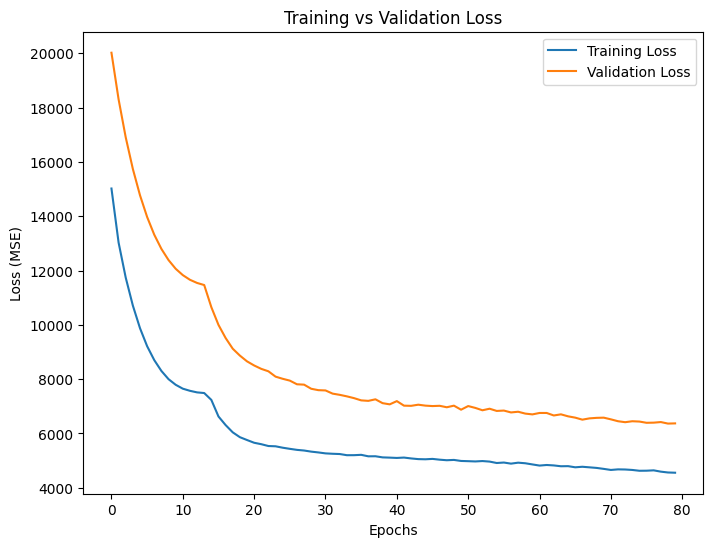

959/959 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Final Training RMSE: 68.55


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot training and validation loss
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.show()

# Calculate final training RMSE
train_predictions = model.predict(X_train_scaled)
train_rmse = np.sqrt(np.mean((y_train - train_predictions.flatten())**2))
print(f"Final Training RMSE: {train_rmse:.2f}")

In [ ]:
# Prepare test data
X_test = test.drop(['No'], axis=1)          # drop unnecessary column
X_test_scaled = scaler.transform(X_test)    # scale using train scaler
X_test_scaled = np.expand_dims(X_test_scaled, axis=1)  # reshape for LSTM

# Make predictions
predictions = model.predict(X_test_scaled)

# Ensure predictions do not contain NaN
predictions = np.nan_to_num(predictions)

# Do NOT round predictions — keep as float for Kaggle
predictions = predictions.flatten()

print("Sample predictions:", predictions[:10])

411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step
Sample predictions: [72.45467  73.79596  67.15375  57.398228 47.55545  44.877457 39.50117
 36.636375 33.88863  32.381924]


In [ ]:
import os
os.listdir('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting')

['train.csv', 'test.csv', 'subm_fixed.csv']

In [ ]:
import numpy as np
import pandas as pd

# Round predictions to integers (optional)
predictions_int = np.round(predictions).astype(int)

# Use test datetime index as row ID
df_dates = test.index
df_dates = df_dates.strftime('%Y-%m-%d %-H:%M:%S')  # remove leading zeros

# Prepare final submission
submission = pd.DataFrame({
    'row ID': df_dates,
    'pm2.5': predictions_int
})

# Save CSV
submission.to_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/submission.csv', index=False)
print("Submission saved!")
print(submission.head())

Submission saved!
               row ID  pm2.5
0  2013-07-02 4:00:00     72
1  2013-07-02 5:00:00     74
2  2013-07-02 6:00:00     67
3  2013-07-02 7:00:00     57
4  2013-07-02 8:00:00     48
